In [41]:
import matplotlib.pyplot as plt
import numpy as np
from finite_env import BlackjackFiniteEnv
from agent import BlackjackAgent

In [42]:
# agent and env initializing

env = BlackjackFiniteEnv(num_decks=1)
agent = BlackjackAgent(
    alpha=0.01,      # Learning rate
    gamma=0.99,     # Discount factor for future hands in the deck
    epsilon=1.0,    # Start with full exploration
    epsilon_decay=0.99999, # Decay over many hands
    min_epsilon=0.01  # Minimum exploration rate
)

num_episodes = 800000  # Total number of episodes to train
stats = {"rewards": [], "epsilon": [], "hands_per_episode": []}

Training loop:
Exploration doesnt reach 0

In [43]:
# training loop
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_episode_reward = 0
    ep_hands = 0
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        
        if info.get("hand_ended", False):
            ep_hands += 1
            
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_episode_reward += reward
        agent.decay_epsilon()
        
    stats["rewards"].append(total_episode_reward)
    stats["epsilon"].append(agent.epsilon)
    stats["hands_per_episode"].append(ep_hands)

In [44]:
# Stats for the final episode
final_score = stats["rewards"][-1]
final_hands = stats["hands_per_episode"][-1]
print(f"Total accumulated score for the last episode: {final_score}")
print(f"Number of hands played in the last episode: {final_hands}")

# Stats for the highest scoring episode
best_score = max(stats["rewards"])
best_episode_idx = stats["rewards"].index(best_score)
best_hands = stats["hands_per_episode"][best_episode_idx]
print(f"\nHighest accumulated score in any episode: {best_score}")
print(f"Achieved in episode: {best_episode_idx + 1}")
print(f"Number of hands played in this episode: {best_hands}")

Total accumulated score for the last episode: 3220
Number of hands played in the last episode: 52

Highest accumulated score in any episode: 5397
Achieved in episode: 107
Number of hands played in this episode: 28


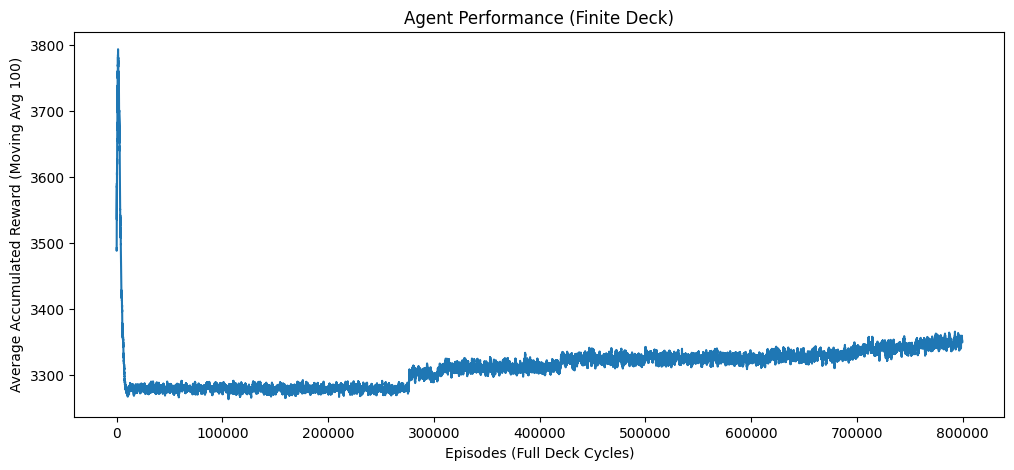

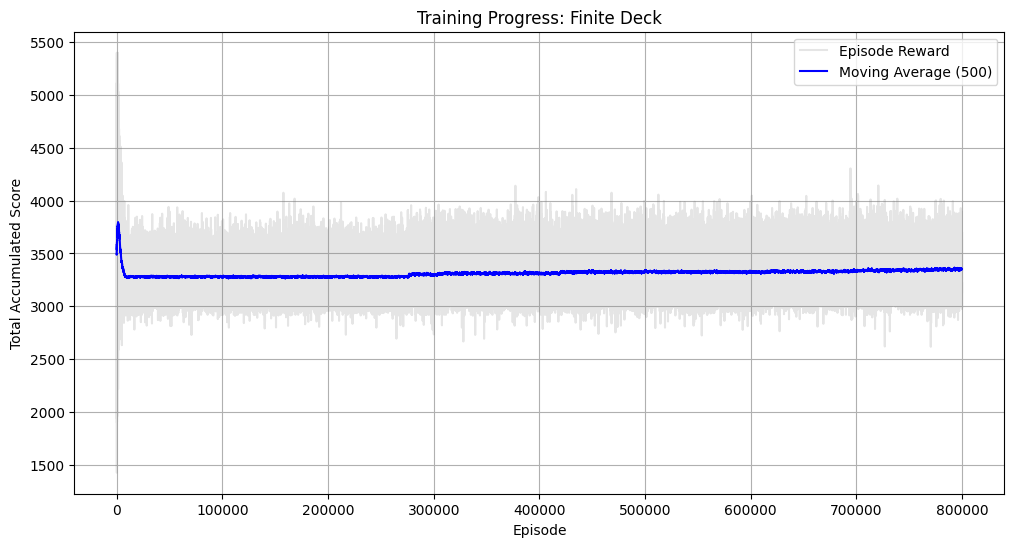

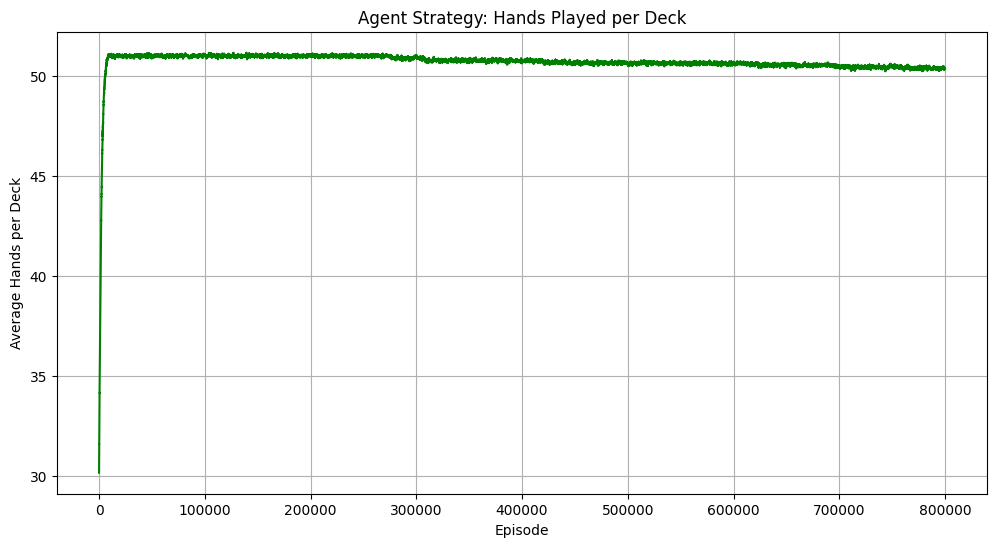

In [45]:
def moving_average(a, n=500):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.figure(figsize=(12, 5))
plt.plot(moving_average(stats["rewards"]))
plt.title("Agent Performance (Finite Deck)")
plt.xlabel("Episodes (Full Deck Cycles)")
plt.ylabel("Average Accumulated Reward (Moving Avg 100)")
plt.show()

def moving_average(data, window_size=500):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))
# Plot the raw rewards in the background (faint)
plt.plot(stats["rewards"], alpha=0.2, color='gray', label='Episode Reward')
# Plot the moving average (solid line)
plt.plot(moving_average(stats["rewards"], 500), color='blue', label='Moving Average (500)')
plt.xlabel('Episode')
plt.ylabel('Total Accumulated Score')
plt.title('Training Progress: Finite Deck')
plt.legend()
plt.grid(True)
plt.show()

# hands per episode
plt.figure(figsize=(12, 6))
plt.plot(moving_average(stats["hands_per_episode"], 500), color='green')
plt.xlabel('Episode')
plt.ylabel('Average Hands per Deck')
plt.title('Agent Strategy: Hands Played per Deck')
plt.grid(True)
plt.show()

Starting Evaluation over 1000 episodes...

       EVALUATION REPORT       
Episodes Evaluated:      1000
Average Score:           3329.74  (Baseline to beat: ~4800)
Highest Score:           3740
Lowest Score:            2950
Score Std Dev:           97.27
----------------------------------------
Avg Hands per Deck:      50.68
Bust Rate:               0.01%
Hit vs Stick Ratio:      2.5% Hits / 97.5% Sticks


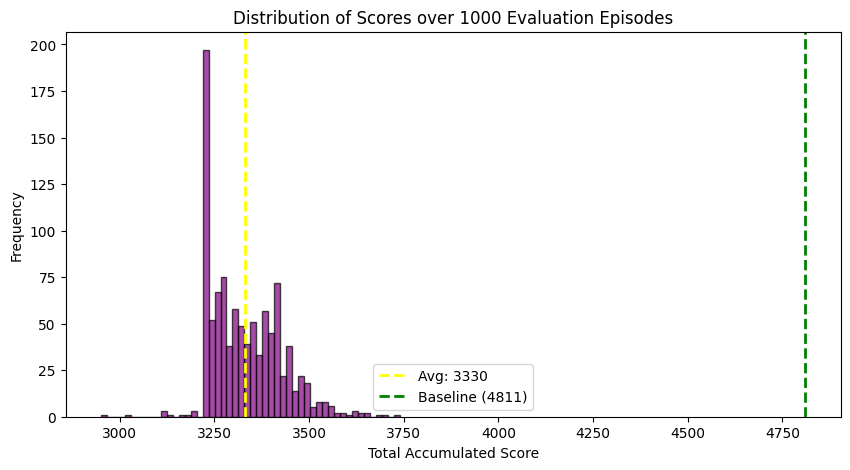

In [46]:
# evaluation phase

n_eval_episodes = 1000
eval_stats = {
    "scores": [],
    "hands_per_episode": [],
    "total_hands": 0,
    "busts": 0,
    "hits": 0,
    "sticks": 0
}

# 1. Force Greedy Policy (Disable Exploration)
original_epsilon = agent.epsilon
agent.epsilon = 0.0 

print(f"Starting Evaluation over {n_eval_episodes} episodes...")

for i in range(n_eval_episodes):
    state = env.reset()
    done = False
    ep_score = 0
    ep_hands = 0
    
    while not done:
        # Purely greedy action based on Q-table
        action = agent.get_action(state)
        
        # Track Action Frequency
        if action == 1:
            eval_stats["hits"] += 1
        else:
            eval_stats["sticks"] += 1
            
        next_state, reward, done, info = env.step(action)
        
        # Track Hand Outcomes
        if info.get("hand_ended", False):
            ep_hands += 1
            eval_stats["total_hands"] += 1
            if info.get("bust", False):
                eval_stats["busts"] += 1
                
        state = next_state
        ep_score += reward
        
    eval_stats["scores"].append(ep_score)
    eval_stats["hands_per_episode"].append(ep_hands)

# 2. Restore Epsilon (in case you want to continue training later)
agent.epsilon = original_epsilon

# 3. Calculate Aggregates
avg_score = np.mean(eval_stats["scores"])
max_score = np.max(eval_stats["scores"])
min_score = np.min(eval_stats["scores"])
std_dev = np.std(eval_stats["scores"])

avg_hands = np.mean(eval_stats["hands_per_episode"])
bust_rate = (eval_stats["busts"] / eval_stats["total_hands"]) * 100 if eval_stats["total_hands"] > 0 else 0
hit_rate = (eval_stats["hits"] / (eval_stats["hits"] + eval_stats["sticks"])) * 100

# 4. Print Report
print("\n" + "="*40)
print("       EVALUATION REPORT       ")
print("="*40)
print(f"Episodes Evaluated:      {n_eval_episodes}")
print(f"Average Score:           {avg_score:.2f}  (Baseline to beat: ~4800)")
print(f"Highest Score:           {max_score}")
print(f"Lowest Score:            {min_score}")
print(f"Score Std Dev:           {std_dev:.2f}")
print("-" * 40)
print(f"Avg Hands per Deck:      {avg_hands:.2f}")
print(f"Bust Rate:               {bust_rate:.2f}%")
print(f"Hit vs Stick Ratio:      {hit_rate:.1f}% Hits / {100-hit_rate:.1f}% Sticks")
print("="*40)

# 5. Visualise Score Distribution
plt.figure(figsize=(10, 5))
plt.hist(eval_stats["scores"], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(avg_score, color='yellow', linestyle='dashed', linewidth=2, label=f'Avg: {avg_score:.0f}')
plt.axvline(4811, color='green', linestyle='dashed', linewidth=2, label='Baseline (4811)')
plt.title(f"Distribution of Scores over {n_eval_episodes} Evaluation Episodes")
plt.xlabel("Total Accumulated Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()